In [1]:
# Firstly, some necessary imports

# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import pickle
import sys
import os
import datetime
import itertools
from aenum import MultiValueEnum

# Basics of Python data handling and visualization
import numpy as np
np.random.seed(42)
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap, BoundaryNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Polygon
from tqdm.auto import tqdm

# Machine learning
import lightgbm as lgb
import joblib
from sklearn import metrics
from sklearn import preprocessing

# Imports from eo-learn and sentinelhub-py
from eolearn.core import EOTask, EOPatch, LinearWorkflow, FeatureType, OverwritePermission, \
    LoadTask, SaveTask, EOExecutor, ExtractBandsTask, MergeFeatureTask
from eolearn.io import SentinelHubInputTask, ExportToTiff
from eolearn.mask import AddMultiCloudMaskTask, AddValidDataMaskTask
from eolearn.geometry import VectorToRaster, PointSamplingTask, ErosionTask
from eolearn.features import LinearInterpolation, SimpleFilterTask, NormalizedDifferenceIndexTask
from sentinelhub import UtmZoneSplitter, BBox, CRS, DataCollection

In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as plt_polygon

from mpl_toolkits.basemap import Basemap  

Dimension of the area is 691819564723 m2


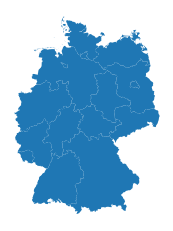

In [15]:
INPUT_FILE = './german.geojson'
# TODO: the area is wrong!!!! review this geojson.
# Load geojson file
country = gpd.read_file(INPUT_FILE)
country_crs = country.to_crs("EPSG:32633")

# Plot country
country_crs.plot()
plt.axis('off');

# Print size 
german_area = 0
for state in country_crs.geometry.values:
    state_area = (state.bounds[2] - state.bounds[0]) * (state.bounds[3] - state.bounds[1])
    german_area += state_area
print('Dimension of the area is {0:.0f} m2'.format(german_area))

Dimension of the area is 344272 x 366681 m2


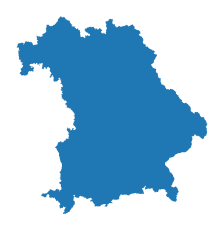

In [16]:
# Get the bayern's shape in polygon format
# TODO: the area is wrong!!!! review this geojson.
bayern = country[country.name=='Bayern']
bayern_shape = bayern.geometry.values[-1]
bayern_crs = country_crs[country_crs.name=='Bayern']
bayern_crs_shape = bayern_crs.geometry.values[-1]

# Plot bayern state
bayern.plot()
plt.axis('off');
# Print size
print('Dimension of the area is {0:.0f} x {1:.0f} m2'.format(bayern_crs_shape.bounds[2] - bayern_crs_shape.bounds[0],
                                                             bayern_crs_shape.bounds[3] - bayern_crs_shape.bounds[1]))

### Splite with UtmZoneSplitter

In [10]:
bbox_splitter = UtmZoneSplitter([bayern_crs_shape], bayern_crs.crs, 5000)

bbox_list = np.array(bbox_splitter.get_bbox_list())
info_list = np.array(bbox_splitter.get_info_list())

# Prepare info of selected EOPatches
geometry = [Polygon(bbox.get_polygon()) for bbox in bbox_list]
idxs = [info['index'] for info in info_list]
idxs_x = [info['index_x'] for info in info_list]
idxs_y = [info['index_y'] for info in info_list]

gdf = gpd.GeoDataFrame({'index': idxs, 'index_x': idxs_x, 'index_y': idxs_y}, 
                           crs=bayern_crs.crs, 
                           geometry=geometry)



In [11]:
# select a 5x5 area (id of center patch)
ID = 1000

# Obtain surrounding 5x5 patches
patchIDs = []
for idx, [bbox, info] in enumerate(zip(bbox_list, info_list)):
    if (abs(info['index_x'] - info_list[ID]['index_x']) <= 2 and
        abs(info['index_y'] - info_list[ID]['index_y']) <= 2):
        patchIDs.append(idx)


# Check if final size is 5x5
if len(patchIDs) != 5*5:
    print('Warning! Use a different central patch ID, this one is on the border.')

# Change the order of the patches (used for plotting later)
patchIDs = np.transpose(np.fliplr(np.array(patchIDs).reshape(5, 5))).ravel()

# save to shapefile
shapefile_name = './grid_bayern_500x500.gpkg'
gdf.to_file(shapefile_name, driver='GPKG')

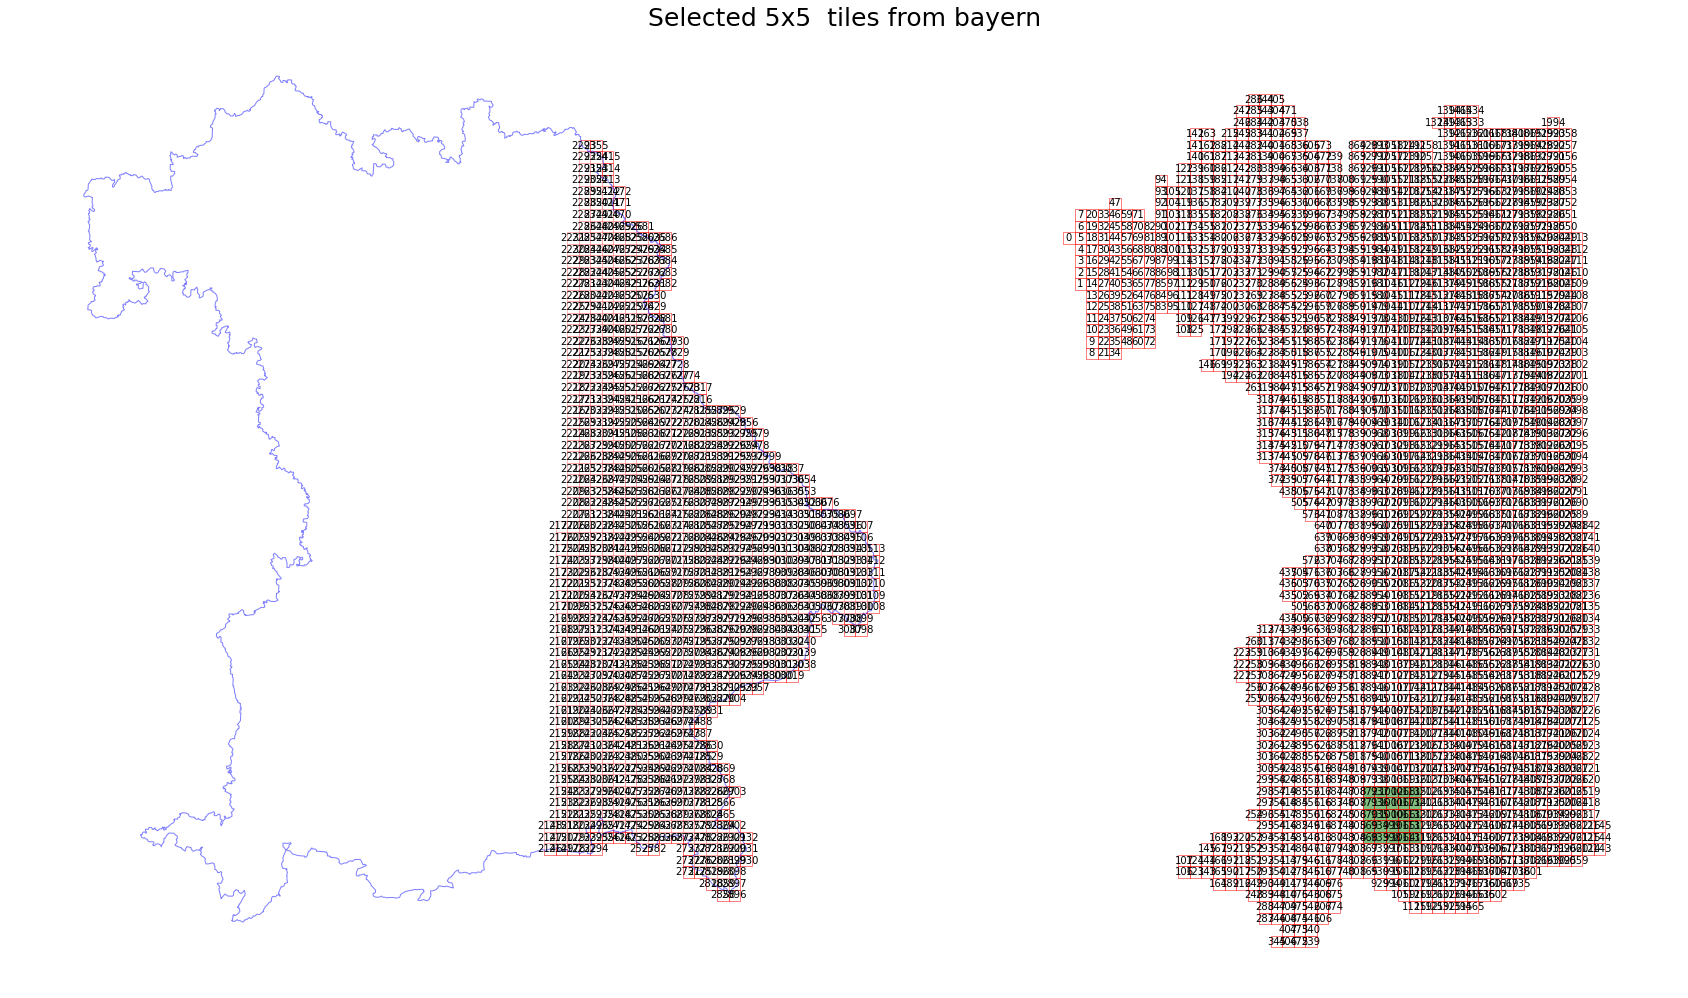

In [13]:
#TODO: have the same problem with https://forum.sentinel-hub.com/t/how-to-use-utmzonesplitter-for-zones-that-span-across-multiple-utm-zones/2316.

# figure
fig, ax = plt.subplots(figsize=(30, 30))
gdf.plot(ax=ax,facecolor='w',edgecolor='r',alpha=0.5)
bayern_crs.plot(ax=ax, facecolor='w',edgecolor='b',alpha=0.5)
ax.set_title('Selected 5x5  tiles from bayern', fontsize=25);
for bbox, info in zip(bbox_list, info_list):
    geo = bbox.geometry
    ax.text(geo.centroid.x, geo.centroid.y, info['index'], ha='center', va='center')

gdf[gdf.index.isin(patchIDs)].plot(ax=ax,facecolor='g',edgecolor='r',alpha=0.5)

plt.axis('off');

In [17]:
class SentinelHubValidData:
    """
    Combine Sen2Cor's classification map with `IS_DATA` to define a `VALID_DATA_SH` mask
    The SentinelHub's cloud mask is asumed to be found in eopatch.mask['CLM']
    """
    def __call__(self, eopatch):
        return np.logical_and(eopatch.mask['IS_DATA'].astype(np.bool),
                              np.logical_not(eopatch.mask['CLM'].astype(np.bool)))

class CountValid(EOTask):
    """
    The task counts number of valid observations in time-series and stores the results in the timeless mask.
    """
    def __init__(self, count_what, feature_name):
        self.what = count_what
        self.name = feature_name

    def execute(self, eopatch):
        eopatch.add_feature(FeatureType.MASK_TIMELESS, self.name, np.count_nonzero(eopatch.mask[self.what],axis=0))

        return eopatch

### Define the workflow tasks

In [18]:
# TASK FOR BAND DATA
# add a request for S2 bands
# Here we also do a simple filter of cloudy scenes (on tile level)
# s2cloudless masks and probabilities are requested via additional data
band_names = ['B02', 'B03', 'B04', 'B08', 'B11', 'B12']
add_data = SentinelHubInputTask(
    bands_feature=(FeatureType.DATA, 'BANDS'),
    bands = band_names,
    resolution=10,
    maxcc=0.8,
    time_difference=datetime.timedelta(minutes=120),
    data_collection=DataCollection.SENTINEL2_L1C,
    additional_data=[(FeatureType.MASK, 'dataMask', 'IS_DATA'),
                     (FeatureType.MASK, 'CLM'),
                     (FeatureType.DATA, 'CLP')],
    max_threads=5
)


# TASKS FOR CALCULATING NEW FEATURES
# NDVI: (B08 - B04)/(B08 + B04)
# NDWI: (B03 - B08)/(B03 + B08)
# NDBI: (B11 - B08)/(B11 + B08)
ndvi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDVI'),
                                     [band_names.index('B08'), band_names.index('B04')])
ndwi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDWI'),
                                     [band_names.index('B03'), band_names.index('B08')])
ndbi = NormalizedDifferenceIndexTask((FeatureType.DATA, 'BANDS'), (FeatureType.DATA, 'NDBI'),
                                     [band_names.index('B11'), band_names.index('B08')])



# TASK FOR VALID MASK
# validate pixels using SentinelHub's cloud detection mask and region of acquisition
add_sh_valmask = AddValidDataMaskTask(SentinelHubValidData(),
                                      'IS_VALID' # name of output mask
                                     )

# TASK FOR COUNTING VALID PIXELS
# count number of valid observations per pixel using valid data mask
count_val_sh = CountValid('IS_VALID', # name of existing mask
                          'VALID_COUNT' # name of output scalar
                         )

# TASK FOR SAVING TO OUTPUT (if needed)
path_out = './eopatches/'
if not os.path.isdir(path_out):
    os.makedirs(path_out)
save = SaveTask(path_out, overwrite_permission=OverwritePermission.OVERWRITE_PATCH)

#### Reference map task

For this example, a subset of the country-wide reference for land-use-land-cover is provided. It is available in the form of a geopackage, which contains polygons and their corresponding labels. The labels represent the following 10 classes:

* lulcid = 0, name = no data
* lulcid = 1, name = cultivated land
* lulcid = 2, name = forest
* lulcid = 3, name = grassland
* lulcid = 4, name = shrubland
* lulcid = 5, name = water
* lulcid = 6, name = wetlands
* lulcid = 7, name = tundra
* lulcid = 8, name = artificial surface
* lulcid = 9, name = bareland
* lulcid = 10, name = snow and ice

We have defined a land cover enum class for ease of use below.

In [19]:
class LULC(MultiValueEnum):
    """ Enum class containing basic LULC types
    """
    NO_DATA            = 'No Data',            0,  '#ffffff'
    CULTIVATED_LAND    = 'Cultivated Land',    1,  '#ffff00'
    FOREST             = 'Forest',             2,  '#054907'
    GRASSLAND          = 'Grassland',          3,  '#ffa500'
    SHRUBLAND          = 'Shrubland',          4,  '#806000'
    WATER              = 'Water',              5,  '#069af3'
    WETLAND            = 'Wetlands',           6,  '#95d0fc'
    TUNDRA             = 'Tundra',             7,  '#967bb6'
    ARTIFICIAL_SURFACE = 'Artificial Surface', 8,  '#dc143c'
    BARELAND           = 'Bareland',           9,  '#a6a6a6'
    SNOW_AND_ICE       = 'Snow and Ice',       10, '#000000'
    
    @property
    def id(self):
        """ Returns an ID of an enum type

        :return: An ID
        :rtype: int
        """
        return self.values[1]

    @property
    def color(self):
        """ Returns class color

        :return: A color in hexadecimal representation
        :rtype: str
        """
        return self.values[2]


def get_bounds_from_ids(ids):
    bounds = []
    for i in range(len(ids)):
        if i < len(ids) - 1:
            if i == 0:
                diff = (ids[i + 1] - ids[i]) / 2
                bounds.append(ids[i] - diff)
            diff = (ids[i + 1] - ids[i]) / 2
            bounds.append(ids[i] + diff)
        else:
            diff = (ids[i] - ids[i - 1]) / 2
            bounds.append(ids[i] + diff)
    return bounds
    

# Reference colormap things
lulc_bounds = get_bounds_from_ids([x.id for x in LULC])
lulc_cmap = ListedColormap([x.color for x in LULC], name="lulc_cmap")
lulc_norm = BoundaryNorm(lulc_bounds, lulc_cmap.N)

In [20]:
# takes some time due to the large size of the reference data
land_use_ref_path = os.path.join(DATA_FOLDER, 'land_use_10class_reference_slovenia_partial.gpkg')
land_use_ref = gpd.read_file(land_use_ref_path)

rasterization_task = VectorToRaster(land_use_ref, (FeatureType.MASK_TIMELESS, 'LULC'),
                                    values_column='lulcid', raster_shape=(FeatureType.MASK, 'IS_DATA'),
                                    raster_dtype=np.uint8)

NameError: name 'DATA_FOLDER' is not defined